### Fetch data directory path

In [119]:
import os
from dotenv import load_dotenv

load_dotenv()
data_dir_path = os.environ['DATA_DIR_PATH']
result_dir_path = os.environ['RESULT_DIR_PATH']

### Import required modules

In [120]:
import h5py
import numpy as np
from matplotlib import pyplot as plt, gridspec

### Utility functions

In [58]:
def show_kspace_slice(kspace_path, slice_idx=0, coil_idxs=[0, 5, 10], cmap='gray'):
    # convert kspace slice to real image
    hf = h5py.File(kspace_path)
    kspace_slice = hf['kspace'][slice_idx]
    kspace_slice = np.log(np.abs(kspace_slice) + 1e-9)
    
    kspace_title = kspace_path.split('/')[-1]
    
    plt.figure()
    plt.suptitle(f'{kspace_title} - slice {slice_idx}')
    for i, coil_idx in enumerate(coil_idxs):
        ax = plt.subplot(1, len(coil_idxs), i + 1)
        plt.title(f'coil {coil_idx}')
        ax.imshow(kspace_slice[coil_idx], cmap=cmap)
        plt.axis('off')  # Remove axes for a cleaner look
    
    plt.show()

In [48]:
def show_image_slice(img_path, slice_idx=0, cmap='gray'):
    img_keys = ['image_grappa', 'image_input', 'image_label']
    img_title = img_path.split('/')[-1]
    
    hf = h5py.File(img_path)
    plt.figure()
    plt.suptitle(f'{img_title} - slice {slice_idx}')
    for j, key in enumerate(img_keys):
        ax = plt.subplot(1, len(img_keys), j + 1)
        img_slice = hf[key][slice_idx]
        plt.title(key)
        ax.imshow(img_slice, cmap=cmap)
        plt.axis('off')  # Remove axes for a cleaner look
    
    plt.show()

In [49]:
def get_masked_kspace_with_1d_mask(kspace, mask):
    """ 아직 미완성~~ """
    mask = np.tile(mask, (mask.shape[0], 1))
    raise NotImplementedError

In [50]:
def show_image_slices(img_path, model_name: str = "", is_recon = True, slice_idxs=[0], cmap='gray'):
    img_title = img_path.split('/')[-1]
    fig_img = plt.figure(figsize=(16, 6))
    gs = gridspec.GridSpec(nrows=1, ncols=len(slice_idxs))
    
    fig_img.suptitle(f'[{model_name}] {img_title}')
    for i, slice_idx in enumerate(slice_idxs):
        with h5py.File(img_path, 'r') as hf:
            img_slice = hf['reconstruction' if is_recon else 'image_label'][slice_idx]
            ax = fig_img.add_subplot(gs[0, i])
            ax.imshow(img_slice, cmap=cmap)
            ax.title.set_text(f'slice {slice_idx}')
            ax.axis('off')  # Remove axes for a cleaner look
    
    fig_img.tight_layout()
    plt.show()
    plt.close(fig_img)

In [51]:
def compare_image_slice(img_paths=None, model_names=None, slice_idx=0, cmap='gray'):
    if img_paths is None:
        img_paths = []
    if len(img_paths) < 1:
        return
    
    img_title = img_paths[0].split('/')[-1]
    fig_img = plt.figure(figsize=(16, 6))
    gs = gridspec.GridSpec(nrows=1, ncols=len(img_paths))
    
    fig_img.suptitle(f'{img_title}')
    for idx, path in enumerate(img_paths):
        with h5py.File(path, 'r') as hf:
            is_recon = path.split('/')[-2] != 'image'
            img_slice = hf['reconstruction' if is_recon else 'image_label'][slice_idx]
            ax = fig_img.add_subplot(gs[0, idx])
            ax.imshow(img_slice, cmap=cmap)
            ax.title.set_text(f'{model_names[idx]}')
            ax.axis('off')  # Remove axes for a cleaner look
    
    fig_img.tight_layout()
    plt.show()
    plt.close(fig_img)

In [107]:
def is_equispaced_mask(mask, acc):
    prev_one_idx = -1
    cnt_not_equispaced = 0
    for idx, val in enumerate(mask):
        if val > 0:
            if (idx - prev_one_idx != acc
            and idx - prev_one_idx != 1
            and prev_one_idx >= 0):
                cnt_not_equispaced += 1
            prev_one_idx = idx
    return cnt_not_equispaced <= 2

In [127]:
def get_center_fractions(mask):
    prev_one_idx = -1
    center = 1
    for idx, val in enumerate(mask):
        if val > 0:
            if prev_one_idx > 0 and idx - prev_one_idx == 1:
                center += 1
            prev_one_idx = idx
    return center / len(mask)

### Data structure

**Image data (train/val)**

In [115]:
img_path = f'{data_dir_path}/train/image/brain_acc4_1.h5'
img = h5py.File(img_path)
print(img.keys())

<KeysViewHDF5 ['image_grappa', 'image_input', 'image_label']>


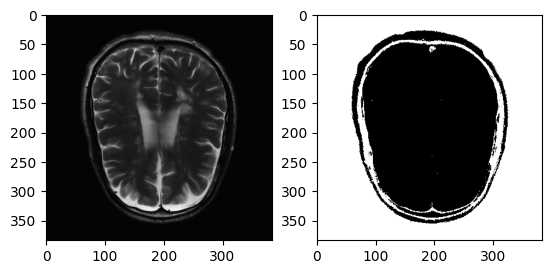

In [150]:
img_path = f'{data_dir_path}/train/image/brain_acc4_1.h5'
img = h5py.File(img_path)
target = img['image_label'][1]
mask = np.zeros(target.shape)
mask[target <= 5e-5] = 1
plt.subplot(1, 2, 1)
plt.imshow(target, cmap='gray')
plt.subplot(1, 2, 2)
plt.imshow(mask, cmap='gray')

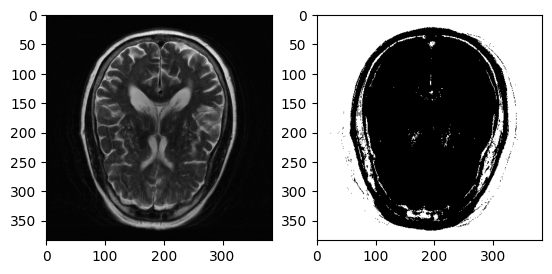

In [155]:
img_path = f'{data_dir_path}/leaderboard/acc5/image/brain_test5.h5'
img = h5py.File(img_path)
target = img['image_label'][1]
mask = np.zeros(target.shape)
mask[target <= 5e-5] = 1
plt.subplot(1, 2, 1)
plt.imshow(target, cmap='gray')
plt.subplot(1, 2, 2)
plt.imshow(mask, cmap='gray')

(16, 384, 384)


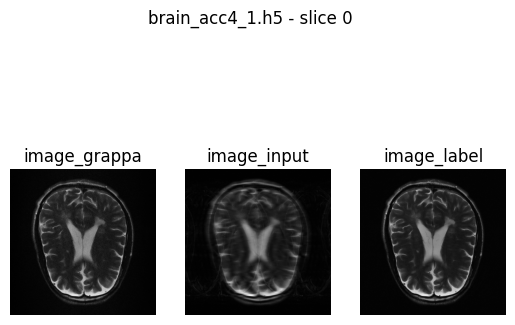

In [116]:
print(img['image_input'].shape)
show_image_slice(img_path)

**Kspace data (train/val)**

In [156]:
kspace_path = f'{data_dir_path}/train/kspace/brain_acc4_1.h5'
kspace = h5py.File(kspace_path)
print(kspace.keys())

<KeysViewHDF5 ['kspace', 'mask']>


In [169]:
print(kspace['kspace'][0][0][0][0].imag)

1.0849908e-07


In [132]:
cnt_total_mask = 118
cnt_equispaced_mask = 0
acc = 4
for i in range(1, cnt_total_mask + 1):
    kspace_path = f'{data_dir_path}/train/kspace/brain_acc{acc}_{i}.h5'
    kspace = h5py.File(kspace_path)
    cnt_equispaced_mask += is_equispaced_mask(kspace['mask'][()], acc=acc)

print(f'# of equispaced masks: {cnt_equispaced_mask} / {cnt_total_mask}')

0.08333333333333333
0.08333333333333333
0.08333333333333333
0.08333333333333333
0.08333333333333333
0.08333333333333333
0.08333333333333333
0.08333333333333333
0.08333333333333333
0.08333333333333333
0.08333333333333333
0.08333333333333333
0.08418367346938775
0.08333333333333333
0.08333333333333333
0.08333333333333333
0.08333333333333333
0.08333333333333333
0.08333333333333333
0.08333333333333333
0.08333333333333333
0.08333333333333333
0.08333333333333333
0.08333333333333333
0.08333333333333333
0.08333333333333333
0.08333333333333333
0.08333333333333333
0.08333333333333333
0.08333333333333333
0.08333333333333333
0.08333333333333333
0.08333333333333333
0.08333333333333333
0.08418367346938775
0.08333333333333333
0.08333333333333333
0.08333333333333333
0.08418367346938775
0.08333333333333333
0.08333333333333333
0.08333333333333333
0.08333333333333333
0.08333333333333333
0.08333333333333333
0.08333333333333333
0.08333333333333333
0.08333333333333333
0.08333333333333333
0.08333333333333333


(396,)
(16, 16, 768, 396)


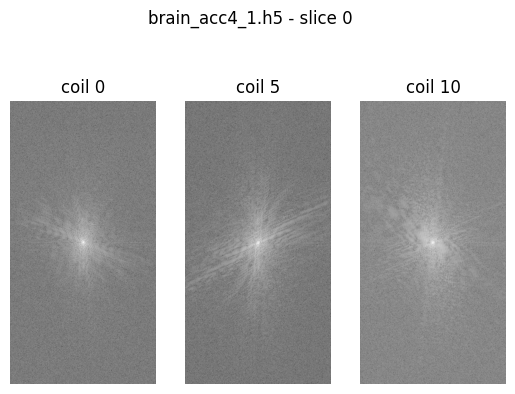

In [75]:
print(kspace['mask'].shape)
print(kspace['kspace'].shape)
show_kspace_slice(kspace_path)

**Image data (leaderboard)**

In [344]:
img_path = f'{data_dir_path}/leaderboard/acc9/image/brain_test2.h5'
img = h5py.File(img_path)
print(img.keys())

<KeysViewHDF5 ['image_grappa', 'image_input', 'image_label']>


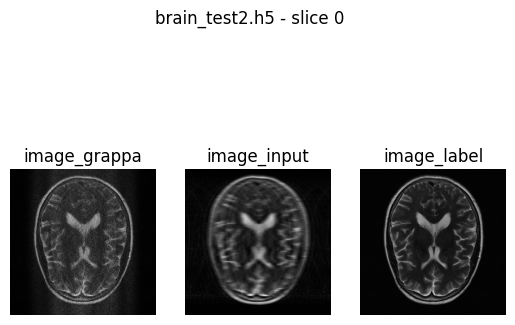

In [345]:
show_image_slice(img_path)

**Kspace data (leaderboard)**

In [77]:
kspace_path = f'{data_dir_path}/leaderboard/acc5/kspace/brain_test1.h5'
kspace = h5py.File(kspace_path)
print(kspace.keys())

<KeysViewHDF5 ['kspace', 'mask']>


In [98]:
cnt_total_mask = 58
cnt_equispaced_mask = 0
for i in range(1, cnt_total_mask + 1):
    kspace_path = f'{data_dir_path}/leaderboard/acc5/kspace/brain_test{i}.h5'
    kspace = h5py.File(kspace_path)
    cnt_equispaced_mask += is_equispaced_mask(kspace['mask'][()], acc=5)

print(f'# of equispaced masks: {cnt_equispaced_mask} / {cnt_total_mask}')

# of equispaced masks: 58 / 58


In [62]:
print(kspace['mask'].shape)
print(kspace['kspace'].shape)

(396,)
(16, 14, 768, 396)


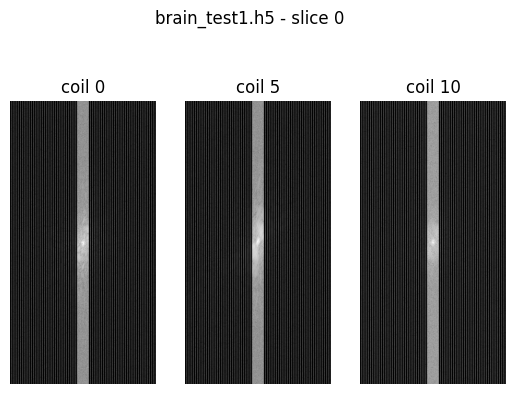

In [63]:
show_kspace_slice(kspace_path)

**정리**
- Image: slices x 384 x 384
- Kspace: slices x coils x 768 x 392/396
- train/val/leaderboard 모두 equispaced mask로 undersampled됨 (일부 mask에 **offset** 존재)
    - center fraction: 0.08~0.084
    - `fastmri.data.subsample.EquispacedMaskFunc()`으로 만들 수 있음

## Mask

In [234]:
img_path = f'{data_dir_path}/leaderboard/acc9/image/brain_test1.h5'
img = h5py.File(img_path)
img_label = img['image_label']

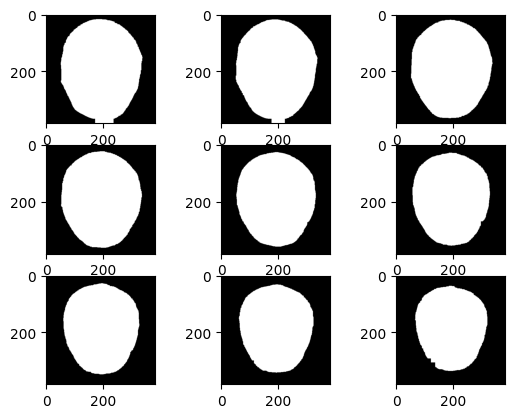

In [235]:
import cv2

for i in range(9):
    target = img['image_label'][i]
    mask = np.zeros(target.shape)
    mask[target > 5e-5] = 1
    kernel = np.ones((3, 3), np.uint8)
    mask = cv2.erode(mask, kernel, iterations=1)
    mask = cv2.dilate(mask, kernel, iterations=15)
    mask = cv2.erode(mask, kernel, iterations=14)
    plt.subplot(3, 3, i+1)
    plt.imshow(mask, cmap='gray')

In [236]:
img_path = f'{data_dir_path}/train/image/brain_acc4_2.h5'
img = h5py.File(img_path)
img_label = img['image_label']
print(img_label.shape)

(16, 384, 384)


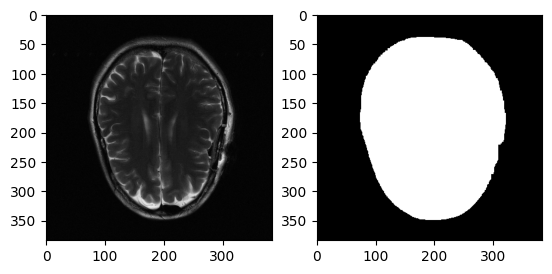

In [237]:
target = img_label[5]

mask = np.zeros(target.shape)
plt.subplot(1, 2, 1)
plt.imshow(target, cmap='gray')

mask[target > 5e-5] = 1
kernel = np.ones((3, 3), np.uint8)
mask = cv2.erode(mask, kernel, iterations=1)
mask = cv2.dilate(mask, kernel, iterations=15)
mask = cv2.erode(mask, kernel, iterations=14)
plt.subplot(1, 2, 2)
plt.imshow(mask, cmap='gray')

## Data Distribution

In [298]:
import glob
def get_mean_list(img_dir):
    img_mean = []
    for img_path in glob.glob(img_dir):
        img = h5py.File(img_path)
        img_mean.append(np.mean(img['image_label']))
    return np.array(img_mean)

def get_var_list(img_dir):
    img_var = []
    for img_path in glob.glob(img_dir):
        img = h5py.File(img_path)
        img_var.append(np.var(img['image_label']))
    return np.array(img_var)

In [348]:
img['image_label'][0]

array([[1.8735205e-05, 2.4931751e-05, 1.8362052e-05, ..., 2.2193075e-05,
        2.5709020e-05, 1.8413226e-05],
       [1.8363608e-05, 2.4478601e-05, 1.6693541e-05, ..., 2.1525066e-05,
        2.4440973e-05, 2.1904505e-05],
       [2.3107041e-05, 2.4893658e-05, 2.1454260e-05, ..., 2.3427530e-05,
        2.2225968e-05, 2.0202155e-05],
       ...,
       [1.6855091e-05, 2.1853279e-05, 2.0993863e-05, ..., 2.5016538e-05,
        2.0799787e-05, 1.6054066e-05],
       [1.9526449e-05, 2.0974672e-05, 2.0006661e-05, ..., 1.7876480e-05,
        2.4555662e-05, 1.4184588e-05],
       [1.5793146e-05, 1.8276818e-05, 1.8467237e-05, ..., 1.9624003e-05,
        1.6134409e-05, 2.4147414e-05]], dtype=float32)

In [274]:
train_img_dir = f'{data_dir_path}/train/image/*'
val_img_dir = f'{data_dir_path}/val/image/*'
leaderboard_img_dir = f'{data_dir_path}/leaderboard/*/image/*'

train_img_mean = get_mean_list(train_img_dir)
val_img_mean = get_mean_list(val_img_dir)
leaderboard_img_mean = get_mean_list(leaderboard_img_dir)

train_img_var = get_var_list(train_img_dir)
val_img_var = get_var_list(val_img_dir)
leaderboard_img_var = get_var_list(leaderboard_img_dir)

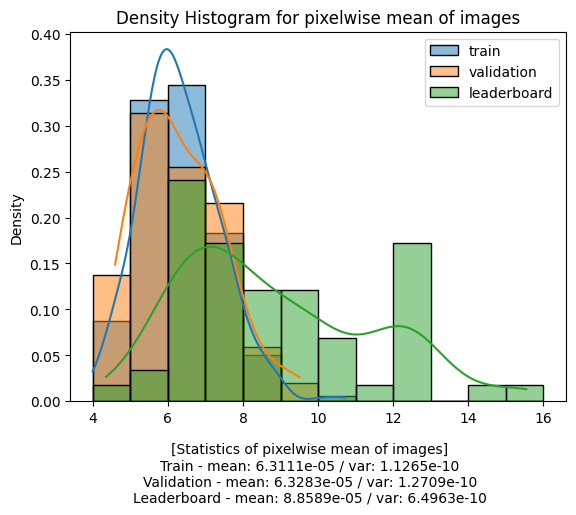

In [334]:
import matplotlib.pyplot as plt
import seaborn as sns

sns.histplot(data=train_img_mean * 1e5, label="train", stat="density", binwidth=1, binrange=(4, 16),  kde=True)
sns.histplot(data=val_img_mean * 1e5, label="validation", stat="density", binwidth=1, binrange=(4, 16), kde=True)
sns.histplot(data=leaderboard_img_mean * 1e5, label="leaderboard", stat="density", binwidth=1, binrange=(4, 16), kde=True)

plt.title("Density Histogram for pixelwise mean of images")
caption = f"""[Statistics of pixelwise mean of images]
Train - mean: {np.mean(train_img_mean):.4e} / var: {np.var(train_img_mean):.4e}
Validation - mean: {np.mean(val_img_mean):.4e} / var: {np.var(val_img_mean):.4e}
Leaderboard - mean: {np.mean(leaderboard_img_mean):.4e} / var: {np.var(leaderboard_img_mean):.4e}"""
plt.figtext(0.5, -0.1, caption, horizontalalignment="center")
plt.legend()

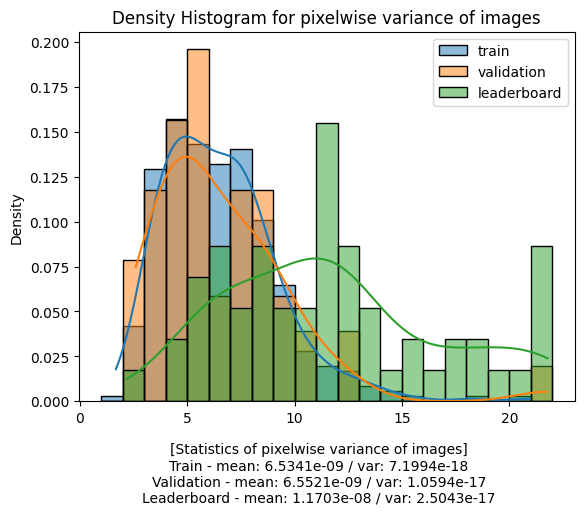

In [335]:
sns.histplot(data=train_img_var * 1e9, label="train", stat="density", binwidth=1, binrange=(1, 22), kde=True)
sns.histplot(data=val_img_var * 1e9, label="validation", stat="density", binwidth=1, binrange=(1, 22), kde=True)
sns.histplot(data=leaderboard_img_var * 1e9, label="leaderboard", stat="density", binwidth=1, binrange=(1, 22), kde=True)

plt.title("Density Histogram for pixelwise variance of images")
caption = f"""[Statistics of pixelwise variance of images]
Train - mean: {np.mean(train_img_var):.4e} / var: {np.var(train_img_var):.4e}
Validation - mean: {np.mean(val_img_var):.4e} / var: {np.var(val_img_var):.4e}
Leaderboard - mean: {np.mean(leaderboard_img_var):.4e} / var: {np.var(leaderboard_img_var):.4e}"""
plt.figtext(0.5, -0.1, caption, horizontalalignment="center")
plt.legend()

train/val dataset에 비해 leaderboard dataset의 평균/분산의 분포가 더 넓다